# Visual Reasoning Baseline Model

1. Data preprocessing 어떻게 하면될까?
 - Image feature를 resnet으로 미리 추출해둘까? --> baseline돌리기 까다로움
 - DataLoader 구성을 어떻게하면 좋을까? --> DataSet class 안에서 feature를 return 할까? 아니면 ResNet을 밖에둘까


2. Baseline Model 설계를 어떻게?
 - Encoder: image encoding 어떻게 하면 될까? Answer Image 3개를 한꺼번에 encoding? 혹은 각각 encoding 한 후 Weight Sum??
 - Decoder: Answer 후보 중 정답후보를 어떻게 고를까? Similarity 기준? KL 같은 분포기준? Attention 기반 Scoring??


3. SOTA Model 설계를 어떻게? 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. Import all packages

In [2]:
import pandas as pd
import numpy as np
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from PIL import Image, ImageDraw
import cv2

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm
#fm.get_fontconfig_fonts()
#font_location = './NanumGothic.ttf'
#font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#matplotlib.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.


In [3]:
'''
nrows,ncols=6,15
fig,ax = plt.subplots(nrows,ncols,figsize=(15,6))
plt.subplots_adjust(wspace=0, hspace=0) 
for i,j in enumerate(malignant[:nrows*ncols]):
    fname = os.path.join(imgpath ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='red')
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')
    
import plotly.express as px

# Create grid of sample images 
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')
image indices: [1438  355 2681 1007 2970 2925  605 1739  270 1641 1080  786 1840   62
 2633  734 1712  511 2681 2973  180 2601  500 1959  869    3 2359 3153
  345 1307]
torch.Size([3, 146, 482])
'''


'\nnrows,ncols=6,15\nfig,ax = plt.subplots(nrows,ncols,figsize=(15,6))\nplt.subplots_adjust(wspace=0, hspace=0) \nfor i,j in enumerate(malignant[:nrows*ncols]):\n    fname = os.path.join(imgpath ,j +\'.tif\')\n    img = Image.open(fname)\n    idcol = ImageDraw.Draw(img)\n    idcol.rectangle(((0,0),(95,95)),outline=\'red\')\n    plt.subplot(nrows, ncols, i+1) \n    plt.imshow(np.array(img))\n    plt.axis(\'off\')\n    \nimport plotly.express as px\n\n# Create grid of sample images \ngrid_size=30\nrnd_inds=np.random.randint(0,len(train_ts),grid_size)\nprint("image indices:",rnd_inds)\n\nx_grid_train=[train_ts[i][0] for i in rnd_inds]\ny_grid_train=[train_ts[i][1] for i in rnd_inds]\n\nx_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)\nprint(x_grid_train.shape)\n    \nplot_img(x_grid_train,y_grid_train,\'Training Subset Examples\')\nimage indices: [1438  355 2681 1007 2970 2925  605 1739  270 1641 1080  786 1840   62\n 2633  734 1712  511 2681 2973  180 2601  500 1959  869   

## 2. Preparation of datasets

In [4]:
class Config:
    def __init__(self, args=None):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.distributed = False
        self.gpu_id = "0,1"
        self.HOME_DIR = "./datasets/"
        self.TASK_NAME = "similarity1/"
        self.FOLDER_NAME = "000003/"
        self.IMAGE_LIST = [
                "0d73dee440ef4291ae926fb5cb4ec55e.jpg", 
                "18f827e0d01742d495d3ecbaffb6255a.jpg", 
                "1b243a095866423da8f4a8f19d78ecf4.jpg",
                "4db9fa5bd947497d91bffd8de3b07e6e.jpg",
                "95ac10e3608e4abba9407a2a1cae2883.jpg",
                "a05e9630fd754a249b1fba0be5f386ed.jpg",
                "ea1f8a29ba464af4b2b393d4bb50d7c0.jpg"
             ]
        self.JSON_NAME = "000003"+".json"
        self.input_dim = 512
        self.mlp_hidden = 1024


#config = Config()
#a_image_file = config.HOME_DIR+config.TASK_NAME+config.FOLDER_NAME+config.IMAGE_LIST[0]
#a_image = plt.imread(a_image_file)
#plt.imshow(a_image)

In [5]:
def get_data(config):
    
    home_dir = config.HOME_DIR
    task_name = config.TASK_NAME
    dir_list = os.listdir(home_dir+task_name)
    sample_list = []
    
    for directory in dir_list:
        FOLDER_NAME = directory+"/"
        JSON_NAME = directory+".json"
        FILE_PATH = home_dir+task_name+FOLDER_NAME
        a_data = json.load(open(FILE_PATH+JSON_NAME))
        a_data["file_path"] = FILE_PATH
        a_data["answer1"] = [a_data["Answers"][0]]
        a_data["answer2"] = [a_data["Answers"][1]]
        del a_data["Answers"]
        sample_list.append(a_data)
        
    return sample_list

def get_img_argumentation():
    #이미지 전처리를 위한 이미지 크기 변환 및 각도조정을 위한 transform 선언

    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    
    return transform


In [6]:
class Similarity1_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, config=None, transform=None):
        self.df = df
        self.config = config
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        
        target = sample["correct_answer_group_ID"][0]
        category = sample["category"]
        q_img = sample["file_path"] + sample["Questions"][0]["images"][0]["image_url"]
        a1_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer1"][0]["images"]]
        a2_img = [sample["file_path"] + ans_img["image_url"] for ans_img in sample["answer2"][0]["images"]]
        
        q_img_feature = Image.open(q_img).convert('RGB')  #이미지 데이터를 RGB형태로 읽음 
        q_img_feature = self.transform(q_img_feature)  #이미지 데이터의 크기 및 각도등을 변경
        
        a1_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a1_img]
        a2_img_feature = [self.transform(Image.open(img).convert('RGB')) for img in a2_img]
        
        return {
            "target": target,
            "q_img": q_img_feature,
            "a1_imgs": a1_img_feature,
            "a2_imgs": a2_img_feature
        }
        
    

In [7]:
def make_sequential(in_channels, out_channels, *args, **kwargs):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, *args, **kwargs),
           nn.BatchNorm2d(out_channels),
           nn.ReLu(),
           nn.MaxPool2d(*args, **kwargs))

class VRSimilarity(nn.Module):
    def __init__(self, config):
        super(VRSimilarity, self).__init__()
        
        self.config = config
        self.backborne = torchvision.models.resnet50(pretrained=True)
        self.backborne.fc = nn.Linear(self.backborne.fc.in_features, self.config.input_dim)
        self.fc = nn.Sequential(
                    nn.Linear(self.config.input_dim*4, self.config.mlp_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(self.config.mlp_hidden, 2),
        )

    def forward(self, samples):
        
        #Question Image Feature
        q = self.backborne(samples["q_img"])
        
        #Answer1 Image Feature
        a1_img1 = self.backborne(samples["a1_imgs"][0])
        a1_img2 = self.backborne(samples["a1_imgs"][1])
        a1_img3 = self.backborne(samples["a1_imgs"][2])
        
        #Answer2 Image Feature
        a2_img1 = self.backborne(samples["a2_imgs"][0])
        a2_img2 = self.backborne(samples["a2_imgs"][1])
        a2_img3 = self.backborne(samples["a2_imgs"][2])
        
        q_a1 = torch.cat([q, a1_img1, a1_img2, a1_img3], axis=1)
        q_a2 = torch.cat([q, a2_img1, a2_img2, a2_img3], axis=1)
        
        q_a1_logit = self.fc(q_a1)
        q_a2_logit = self.fc(q_a2)
        
        return {
            "q_a1_logit": F.log_softmax(q_a1_logit, dim=1),
            "q_a2_logit": F.log_softmax(q_a2_logit, dim=1)
        }


In [8]:
def train_fn(model, train_loader, optimizer, loss_fn, config):
    
    total_count_correct = 0
    total_num_example = 0
    total_loss = []
    
    model.train()
    device = config.device
    
    for batch in tqdm(train_loader):          
        
        #Question Image Feature
        batch["q_img"] = batch["q_img"].to(device)
        
        #Answer1 Image Feature
        batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
        batch["a1_imgs"][1] = batch["a1_imgs"][1].to(device)
        batch["a1_imgs"][2] = batch["a1_imgs"][2].to(device)
        
        #Answer2 Image Feature
        batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
        batch["a2_imgs"][1] = batch["a2_imgs"][1].to(device)
        batch["a2_imgs"][2] = batch["a2_imgs"][2].to(device)
        logits = model(batch)

        target_a1, target_a2 = batch["target"].long().to(device), (batch["target"] == 0).type(torch.long).to(device)
        #print(logits["q_a1_logit"], logits["q_a1_logit"].size())
        #print(target_a1, target_a1.size())
        #loss_a1 = loss_fn(logits["q_a1_logit"].squeeze() if (len(logits["q_a1_logit"].shape) >= 2) else logits["q_a1_logit"], target_a1)
        #loss_a2 = loss_fn(logits["q_a2_logit"].squeeze() if (len(logits["q_a2_logit"].shape) >= 2) else logits["q_a2_logit"], target_a2)
        loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
        loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
        #print(loss_a1.item())
        
        loss = loss_a1 + loss_a2
        #print(loss.item())
        total_loss.append(loss.item())
        
        #predicted_a1 = (torch.sigmoid(logits["q_a1_logit"]) > 0.5).float()
        predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
        total_num_example = total_num_example + target_a1.size(0)
        
        #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
        predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
        total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
        total_num_example = total_num_example + target_a2.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("total_count_correct", total_count_correct)
        print("total_num_example", total_num_example)
        
    print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )
    return sum(total_loss)/total_num_example, total_count_correct/total_num_example


In [9]:
def valid_fn(model, train_loader, loss_fn, config):
    
    total_count_correct = 0
    total_num_example = 0
    total_loss = []
    
    model.eval()
    device = config.device
    
    with torch.no_grad():
        for batch in tqdm(valid_loader):          
            #Question Image Feature
            batch["q_img"] = batch["q_img"].to(device)

            #Answer1 Image Feature
            batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
            batch["a1_imgs"][1] = batch["a1_imgs"][1].to(device)
            batch["a1_imgs"][2] = batch["a1_imgs"][2].to(device)

            #Answer2 Image Feature
            batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
            batch["a2_imgs"][1] = batch["a2_imgs"][1].to(device)
            batch["a2_imgs"][2] = batch["a2_imgs"][2].to(device)
            logits = model(batch)

            target_a1, target_a2 = batch["target"].long().to(device), (batch["target"] == 0).type(torch.long).to(device)
            #print(logits["q_a1_logit"], logits["q_a1_logit"].size())
            #print(target_a1, target_a1.size())
            #loss_a1 = loss_fn(logits["q_a1_logit"].squeeze() if (len(logits["q_a1_logit"].shape) >= 2) else logits["q_a1_logit"], target_a1)
            #loss_a2 = loss_fn(logits["q_a2_logit"].squeeze() if (len(logits["q_a2_logit"].shape) >= 2) else logits["q_a2_logit"], target_a2)
            loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
            loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
            #print(loss_a1.item())

            loss = loss_a1 + loss_a2
            #print(loss.item())
            total_loss.append(loss.item())

            #predicted_a1 = (torch.sigmoid(logits["q_a1_logit"]) > 0.5).float()
            predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
            total_num_example = total_num_example + target_a1.size(0)

            #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
            predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
            total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
            total_num_example = total_num_example + target_a2.size(0)
        
        
    print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )
    return sum(total_loss)/total_num_example, total_count_correct/total_num_example


In [10]:
# def valid_fn(model, train_loader, config):
    
#     total_count_correct = 0
#     total_num_example = 0
#     total_loss = []
    
#     model.eval()
#     device = config.device
    
#     for batch in tqdm(train_loader):          
        
#         #Question Image Feature
#         batch["q_img"] = batch["q_img"].to(device)
        
#         #Answer1 Image Feature
#         batch["a1_imgs"][0] = batch["a1_imgs"][0].to(device)
#         batch["a1_imgs"][1] = batch["a1_imgs"][1].to(device)
#         batch["a1_imgs"][2] = batch["a1_imgs"][2].to(device)
        
#         #Answer2 Image Feature
#         batch["a2_imgs"][0] = batch["a2_imgs"][0].to(device)
#         batch["a2_imgs"][1] = batch["a2_imgs"][1].to(device)
#         batch["a2_imgs"][2] = batch["a2_imgs"][2].to(device)
#         logits = model(batch)

#         target_a1, target_a2 = batch["target"].long().to(device), (batch["target"] == 0).type(torch.long).to(device)
#         #print(logits["q_a1_logit"], logits["q_a1_logit"].size())
#         #print(target_a1, target_a1.size())
#         #loss_a1 = loss_fn(logits["q_a1_logit"].squeeze() if (len(logits["q_a1_logit"].shape) >= 2) else logits["q_a1_logit"], target_a1)
#         #loss_a2 = loss_fn(logits["q_a2_logit"].squeeze() if (len(logits["q_a2_logit"].shape) >= 2) else logits["q_a2_logit"], target_a2)
#         loss_a1 = loss_fn(logits["q_a1_logit"].squeeze(), target_a1)
#         loss_a2 = loss_fn(logits["q_a2_logit"].squeeze(), target_a2)
#         #print(loss_a1.item())
        
#         loss = loss_a1 + loss_a2
#         #print(loss.item())
#         total_loss.append(loss.item())
        
#         #predicted_a1 = (torch.sigmoid(logits["q_a1_logit"]) > 0.5).float()
#         predicted_a1 = logits["q_a1_logit"].argmax(dim=1, keepdim=True).squeeze()
#         total_count_correct = total_count_correct + torch.sum(predicted_a1 == target_a1).item()
#         total_num_example = total_num_example + target_a1.size(0)
        
#         #predicted_a2 = (torch.sigmoid(logits["q_a2_logit"]) > 0.5).float()
#         predicted_a2 = logits["q_a2_logit"].argmax(dim=1, keepdim=True).squeeze()
#         total_count_correct = total_count_correct + torch.sum(predicted_a2 == target_a2).item()
#         total_num_example = total_num_example + target_a2.size(0)
        
#     print("LOSS:", str(sum(total_loss)/total_num_example) + " Accuracy: " + str(total_count_correct/total_num_example) )
#     return sum(total_loss)/total_num_example, total_count_correct/total_num_example


In [11]:
config = Config()

sample_list = get_data(config)
df = pd.DataFrame(sample_list)
df.drop(df[df["doc_id"] == "000769"].index, inplace=True)
df.drop(df[df["doc_id"] == "000256"].index, inplace=True)
train_df, valid_df = train_test_split(df)
transform = get_img_argumentation()


train_datasets = Similarity1_Dataset(train_df, transform=transform)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=32, num_workers = 32)

valid_datasets = Similarity1_Dataset(valid_df, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_datasets, batch_size=32, num_workers = 32)

vrs1_model = VRSimilarity(config)
#vrs1_model = torch.nn.DataParallel(vrs1_model)
vrs1_model = vrs1_model.to(config.device)

if config.distributed:
    #model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[config.gpu])    
    model = torch.nn.parallel.DistributedDataParallel(model)    

optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.0001)
#loss_fn = nn.BCELoss()
loss_fn = nn.NLLLoss(reduction="sum")


In [12]:
optimizer = torch.optim.Adam(vrs1_model.parameters(), lr=0.001)
total_train_loss = []
total_train_acc = []
total_valid_loss = []
total_valid_acc = []

for epoch in tqdm(range(30)):
    train_loss, train_acc = train_fn(vrs1_model, train_loader, optimizer, loss_fn, config)
    vali_loss, vali_acc = valid_fn(vrs1_model, valid_loader, loss_fn, config)
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    total_valid_loss.append(vali_loss)
    total_valid_acc.append(vali_acc)

  1%|▏         | 1/74 [00:04<05:04,  4.17s/it]

total_count_correct 31
total_num_example 64



  3%|▎         | 2/74 [00:04<02:31,  2.10s/it]

total_count_correct 60
total_num_example 128



  4%|▍         | 3/74 [00:05<01:39,  1.40s/it]

total_count_correct 92
total_num_example 192



  5%|▌         | 4/74 [00:05<01:15,  1.08s/it]

total_count_correct 124
total_num_example 256



  7%|▋         | 5/74 [00:06<01:03,  1.09it/s]

total_count_correct 156
total_num_example 320



  8%|▊         | 6/74 [00:07<00:54,  1.25it/s]

total_count_correct 188
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.38it/s]

total_count_correct 220
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.48it/s]

total_count_correct 251
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 283
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 317
total_num_example 640



 15%|█▍        | 11/74 [00:10<00:38,  1.66it/s]

total_count_correct 349
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 381
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.71it/s]

total_count_correct 413
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 445
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 477
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.74it/s]

total_count_correct 509
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 541
total_num_example 1088



 24%|██▍       | 18/74 [00:14<00:32,  1.75it/s]

total_count_correct 575
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 607
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 639
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 671
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 699
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 727
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 759
total_num_example 1536



 34%|███▍      | 25/74 [00:18<00:28,  1.75it/s]

total_count_correct 791
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 823
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:27,  1.73it/s]

total_count_correct 856
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.74it/s]

total_count_correct 885
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.74it/s]

total_count_correct 915
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 947
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 979
total_num_example 1984



 43%|████▎     | 32/74 [00:22<00:24,  1.74it/s]

total_count_correct 1011
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.73it/s]

total_count_correct 1043
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.71it/s]

total_count_correct 1073
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.72it/s]

total_count_correct 1105
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.73it/s]

total_count_correct 1136
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.70it/s]

total_count_correct 1169
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 1205
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.73it/s]

total_count_correct 1232
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1266
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1299
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1331
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1364
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1390
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1425
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:15,  1.75it/s]

total_count_correct 1451
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1487
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1511
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.76it/s]

total_count_correct 1536
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.76it/s]

total_count_correct 1571
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.76it/s]

total_count_correct 1602
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.76it/s]

total_count_correct 1633
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 1672
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 1705
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 1742
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 1775
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 1808
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 1838
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.74it/s]

total_count_correct 1871
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 1905
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 1937
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 1971
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2004
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2038
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 2065
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 2099
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.73it/s]

total_count_correct 2138
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 2163
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 2167
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 2199
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 2216
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 2260
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 2302
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 2323
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.7588933545189935 Accuracy: 0.4904983108108108



  3%|▎         | 1/30 [00:54<26:34, 54.98s/it]

LOSS: 0.7101837954943693 Accuracy: 0.5215189873417722



  1%|▏         | 1/74 [00:04<04:58,  4.09s/it]

total_count_correct 32
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.03s/it]

total_count_correct 45
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 74
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.07s/it]

total_count_correct 112
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 139
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 158
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 191
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 227
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 260
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 296
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:37,  1.66it/s]

total_count_correct 327
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.69it/s]

total_count_correct 373
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.71it/s]

total_count_correct 413
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 454
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 495
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.74it/s]

total_count_correct 537
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 558
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 601
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 632
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 662
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 689
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 710
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 742
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 761
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.76it/s]

total_count_correct 801
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.76it/s]

total_count_correct 840
total_num_example 1664



 36%|███▋      | 27/74 [00:18<00:26,  1.76it/s]

total_count_correct 877
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 912
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.76it/s]

total_count_correct 948
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 982
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.76it/s]

total_count_correct 1017
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.76it/s]

total_count_correct 1048
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1081
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:22,  1.74it/s]

total_count_correct 1127
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1158
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.71it/s]

total_count_correct 1189
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.69it/s]

total_count_correct 1222
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 1256
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.72it/s]

total_count_correct 1291
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1330
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.74it/s]

total_count_correct 1365
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1407
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1441
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1477
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1515
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:15,  1.75it/s]

total_count_correct 1556
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1596
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1641
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 1679
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 1711
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 1742
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 1774
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:11,  1.75it/s]

total_count_correct 1827
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 1869
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 1908
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 1942
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 1998
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2041
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2074
total_num_example 3776



 81%|████████  | 60/74 [00:37<00:07,  1.75it/s]

total_count_correct 2108
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2166
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2213
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2250
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2288
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 2333
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 2365
total_num_example 4224



 91%|█████████ | 67/74 [00:41<00:04,  1.74it/s]

total_count_correct 2390
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 2429
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 2469
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 2501
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 2535
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 2571
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 2608
total_num_example 4672



100%|██████████| 74/74 [00:45<00:00,  1.74it/s]

total_count_correct 2654
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6782643134529526 Accuracy: 0.5603885135135135



  7%|▋         | 2/30 [01:49<25:36, 54.88s/it]

LOSS: 0.6820460066010681 Accuracy: 0.5626582278481013



  1%|▏         | 1/74 [00:04<04:59,  4.11s/it]

total_count_correct 42
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.04s/it]

total_count_correct 71
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 112
total_num_example 192



  5%|▌         | 4/74 [00:05<01:16,  1.10s/it]

total_count_correct 155
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.10it/s]

total_count_correct 200
total_num_example 320



  8%|▊         | 6/74 [00:07<00:56,  1.20it/s]

total_count_correct 239
total_num_example 384



  9%|▉         | 7/74 [00:07<00:50,  1.34it/s]

total_count_correct 271
total_num_example 448



 11%|█         | 8/74 [00:08<00:45,  1.45it/s]

total_count_correct 320
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:42,  1.53it/s]

total_count_correct 356
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:40,  1.59it/s]

total_count_correct 388
total_num_example 640



 15%|█▍        | 11/74 [00:10<00:38,  1.64it/s]

total_count_correct 427
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.67it/s]

total_count_correct 453
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:36,  1.69it/s]

total_count_correct 488
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 522
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 565
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 598
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 644
total_num_example 1088



 24%|██▍       | 18/74 [00:14<00:32,  1.74it/s]

total_count_correct 684
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 723
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 742
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 750
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 778
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 818
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 830
total_num_example 1536



 34%|███▍      | 25/74 [00:18<00:27,  1.75it/s]

total_count_correct 869
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 906
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 944
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 977
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1020
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1066
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1092
total_num_example 1984



 43%|████▎     | 32/74 [00:22<00:23,  1.75it/s]

total_count_correct 1134
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.75it/s]

total_count_correct 1176
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:22,  1.75it/s]

total_count_correct 1228
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.75it/s]

total_count_correct 1259
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.73it/s]

total_count_correct 1270
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.74it/s]

total_count_correct 1287
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.72it/s]

total_count_correct 1296
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.73it/s]

total_count_correct 1346
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.74it/s]

total_count_correct 1402
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1428
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1476
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 1509
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1542
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.74it/s]

total_count_correct 1595
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.75it/s]

total_count_correct 1642
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1681
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1720
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 1763
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 1804
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 1850
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 1891
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 1932
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 1983
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2027
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2068
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2109
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2161
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2204
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:07,  1.75it/s]

total_count_correct 2255
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2306
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2364
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2423
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2475
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 2506
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.75it/s]

total_count_correct 2542
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:03,  1.75it/s]

total_count_correct 2587
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 2619
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 2652
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 2685
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 2717
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 2751
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 2793
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.74it/s]

total_count_correct 2849
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6657219041843672 Accuracy: 0.6015625



 10%|█         | 3/30 [02:44<24:42, 54.89s/it]

LOSS: 0.6894801477842694 Accuracy: 0.529746835443038



  1%|▏         | 1/74 [00:04<04:58,  4.09s/it]

total_count_correct 63
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.02s/it]

total_count_correct 114
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 146
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.05s/it]

total_count_correct 182
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.12it/s]

total_count_correct 215
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 247
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 286
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 331
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 360
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 392
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.66it/s]

total_count_correct 424
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 448
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 481
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 522
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 554
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 586
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 623
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 652
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 703
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 730
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 772
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 814
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 848
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 878
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.75it/s]

total_count_correct 915
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 966
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1008
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1036
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1077
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1124
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1159
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1209
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:24,  1.69it/s]

total_count_correct 1248
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.71it/s]

total_count_correct 1280
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.72it/s]

total_count_correct 1325
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.73it/s]

total_count_correct 1357
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.70it/s]

total_count_correct 1389
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.72it/s]

total_count_correct 1420
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.73it/s]

total_count_correct 1453
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1510
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1542
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1593
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 1651
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1709
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1755
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.75it/s]

total_count_correct 1789
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1840
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1870
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 1930
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 1984
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2016
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2067
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:11,  1.75it/s]

total_count_correct 2099
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2133
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2165
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2209
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2235
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2267
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2308
total_num_example 3776



 81%|████████  | 60/74 [00:37<00:08,  1.75it/s]

total_count_correct 2350
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2382
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2422
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2486
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2518
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.72it/s]

total_count_correct 2582
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 2616
total_num_example 4224



 91%|█████████ | 67/74 [00:41<00:04,  1.74it/s]

total_count_correct 2647
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 2680
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 2721
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 2774
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 2812
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 2821
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 2866
total_num_example 4672



100%|██████████| 74/74 [00:45<00:00,  1.75it/s]

total_count_correct 2898
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6694898408006977 Accuracy: 0.6119087837837838



 13%|█▎        | 4/30 [03:39<23:46, 54.88s/it]

LOSS: 0.6968580813347539 Accuracy: 0.4981012658227848



  1%|▏         | 1/74 [00:04<04:59,  4.10s/it]

total_count_correct 32
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 71
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.37s/it]

total_count_correct 103
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 152
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 184
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 216
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 234
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 266
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 313
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 357
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 390
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 450
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 490
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 545
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 579
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 598
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 649
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 681
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 712
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 745
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 778
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 813
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 861
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 900
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 930
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 972
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.74it/s]

total_count_correct 1006
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1040
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.74it/s]

total_count_correct 1078
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.73it/s]

total_count_correct 1113
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1154
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.74it/s]

total_count_correct 1188
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.72it/s]

total_count_correct 1223
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1255
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1288
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.71it/s]

total_count_correct 1345
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:22,  1.68it/s]

total_count_correct 1394
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.70it/s]

total_count_correct 1426
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.72it/s]

total_count_correct 1443
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.72it/s]

total_count_correct 1498
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.73it/s]

total_count_correct 1552
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1584
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1633
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 1687
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1740
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.75it/s]

total_count_correct 1776
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1836
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1892
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 1956
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2001
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2054
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2087
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2107
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2168
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2214
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2268
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2332
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2364
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.74it/s]

total_count_correct 2396
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.74it/s]

total_count_correct 2454
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2486
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.74it/s]

total_count_correct 2524
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.74it/s]

total_count_correct 2576
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.74it/s]

total_count_correct 2609
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.73it/s]

total_count_correct 2643
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 2675
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 2693
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 2723
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 2755
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 2811
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 2861
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 2895
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 2928
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 2972
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6611698149023829 Accuracy: 0.6275337837837838



 17%|█▋        | 5/30 [04:34<22:52, 54.90s/it]

LOSS: 0.6828034582017343 Accuracy: 0.5639240506329114



  1%|▏         | 1/74 [00:04<04:59,  4.10s/it]

total_count_correct 34
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 60
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 92
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.05s/it]

total_count_correct 124
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.13it/s]

total_count_correct 156
total_num_example 320



  8%|▊         | 6/74 [00:07<00:54,  1.24it/s]

total_count_correct 188
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.37it/s]

total_count_correct 223
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.47it/s]

total_count_correct 255
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.55it/s]

total_count_correct 293
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 318
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 375
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 407
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 457
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 488
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 545
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 604
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 665
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 717
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 753
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 785
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 817
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 849
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 881
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 913
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.75it/s]

total_count_correct 945
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 977
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1009
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1060
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1096
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1130
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1186
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1219
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.73it/s]

total_count_correct 1268
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1326
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.73it/s]

total_count_correct 1384
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.74it/s]

total_count_correct 1443
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.74it/s]

total_count_correct 1459
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.68it/s]

total_count_correct 1504
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.70it/s]

total_count_correct 1562
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.72it/s]

total_count_correct 1624
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.73it/s]

total_count_correct 1659
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.73it/s]

total_count_correct 1695
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.73it/s]

total_count_correct 1747
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 1777
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.74it/s]

total_count_correct 1817
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.74it/s]

total_count_correct 1852
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1909
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1954
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2015
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2078
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2109
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2141
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2184
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2217
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2249
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2281
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2344
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2402
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2434
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 2466
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2530
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2593
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2629
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2661
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 2724
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 2781
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 2813
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 2850
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 2882
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 2917
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.73it/s]

total_count_correct 2951
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 2984
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 3016
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.74it/s]

total_count_correct 3048
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.633675445978706 Accuracy: 0.643581081081081



 20%|██        | 6/30 [05:29<21:57, 54.89s/it]

LOSS: 0.7003769693495352 Accuracy: 0.5006329113924051



  1%|▏         | 1/74 [00:04<05:03,  4.16s/it]

total_count_correct 48
total_num_example 64



  3%|▎         | 2/74 [00:04<02:27,  2.05s/it]

total_count_correct 106
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.38s/it]

total_count_correct 170
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.07s/it]

total_count_correct 233
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.12it/s]

total_count_correct 295
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.28it/s]

total_count_correct 357
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 405
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.50it/s]

total_count_correct 439
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 500
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 554
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:37,  1.66it/s]

total_count_correct 587
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.69it/s]

total_count_correct 619
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.71it/s]

total_count_correct 651
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 715
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 778
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.74it/s]

total_count_correct 841
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.73it/s]

total_count_correct 873
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 937
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 1001
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 1035
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 1097
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1142
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1205
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1245
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1277
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1335
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1397
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1428
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1491
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1528
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1592
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1638
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:24,  1.68it/s]

total_count_correct 1670
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.70it/s]

total_count_correct 1734
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.72it/s]

total_count_correct 1788
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.70it/s]

total_count_correct 1820
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.71it/s]

total_count_correct 1861
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.72it/s]

total_count_correct 1916
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.73it/s]

total_count_correct 1948
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.74it/s]

total_count_correct 2005
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 2066
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.75it/s]

total_count_correct 2121
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 2179
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2199
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2252
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:15,  1.75it/s]

total_count_correct 2300
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2363
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2426
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2458
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2508
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2540
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2572
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2604
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2639
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2681
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2728
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2760
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2792
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2824
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:07,  1.75it/s]

total_count_correct 2858
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2893
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2939
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2985
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3019
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.72it/s]

total_count_correct 3065
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 3110
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3152
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3186
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3236
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3299
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3358
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3390
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3422
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3480
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6033044434278398 Accuracy: 0.7347972972972973



 23%|██▎       | 7/30 [06:24<21:02, 54.88s/it]

LOSS: 0.7222902901564973 Accuracy: 0.489873417721519



  1%|▏         | 1/74 [00:04<04:58,  4.09s/it]

total_count_correct 40
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.03s/it]

total_count_correct 99
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 162
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.06s/it]

total_count_correct 224
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.11it/s]

total_count_correct 288
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 346
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 378
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 410
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 442
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 477
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 534
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 582
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 614
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.70it/s]

total_count_correct 667
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.70it/s]

total_count_correct 719
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.71it/s]

total_count_correct 783
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:33,  1.72it/s]

total_count_correct 835
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.73it/s]

total_count_correct 870
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 903
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:31,  1.74it/s]

total_count_correct 965
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 1001
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1035
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1075
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1108
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1140
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1204
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1261
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1300
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.74it/s]

total_count_correct 1355
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.74it/s]

total_count_correct 1416
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1449
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1510
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1543
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.74it/s]

total_count_correct 1603
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1660
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.73it/s]

total_count_correct 1722
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.69it/s]

total_count_correct 1785
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 1849
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.72it/s]

total_count_correct 1881
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1940
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.73it/s]

total_count_correct 1972
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 2036
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 2093
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 2151
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2215
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.73it/s]

total_count_correct 2279
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.73it/s]

total_count_correct 2343
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:15,  1.73it/s]

total_count_correct 2407
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.74it/s]

total_count_correct 2471
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.74it/s]

total_count_correct 2531
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.74it/s]

total_count_correct 2563
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2620
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2661
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.74it/s]

total_count_correct 2725
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.74it/s]

total_count_correct 2789
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.74it/s]

total_count_correct 2829
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2893
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2956
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2999
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 3063
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.74it/s]

total_count_correct 3100
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 3132
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 3196
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3252
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 3284
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 3316
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3370
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3433
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 3465
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3529
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3561
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3593
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3635
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3691
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.48008871136384235 Accuracy: 0.7793496621621622



 27%|██▋       | 8/30 [07:19<20:07, 54.89s/it]

LOSS: 0.7225183740446839 Accuracy: 0.49936708860759493



  1%|▏         | 1/74 [00:04<04:57,  4.07s/it]

total_count_correct 61
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.01s/it]

total_count_correct 120
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 184
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.05s/it]

total_count_correct 248
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 305
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 337
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 399
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 462
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 524
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 576
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 640
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 704
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 736
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 794
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 858
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 890
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 922
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 954
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 1017
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 1048
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 1083
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.74it/s]

total_count_correct 1120
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1184
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1222
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1277
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1340
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1403
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1429
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1461
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1497
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1528
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1560
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.72it/s]

total_count_correct 1592
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1624
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1656
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.73it/s]

total_count_correct 1688
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.69it/s]

total_count_correct 1721
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 1772
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.72it/s]

total_count_correct 1821
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1858
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.74it/s]

total_count_correct 1895
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1927
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1963
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1996
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2028
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.75it/s]

total_count_correct 2071
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2115
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2147
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2189
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2245
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2282
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2314
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:12,  1.75it/s]

total_count_correct 2349
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2408
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2442
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2496
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2528
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2560
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2592
total_num_example 3776



 81%|████████  | 60/74 [00:37<00:07,  1.75it/s]

total_count_correct 2625
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2688
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2749
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2804
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2846
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 2903
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 2966
total_num_example 4224



 91%|█████████ | 67/74 [00:41<00:04,  1.74it/s]

total_count_correct 3002
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 3039
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 3096
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3160
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3191
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3254
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 3288
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


total_count_correct 3345
total_num_example 4736
LOSS: 0.6423946746398468 Accuracy: 0.7062922297297297



 30%|███       | 9/30 [08:13<19:12, 54.88s/it]

LOSS: 0.7162550745131094 Accuracy: 0.49873417721518987



  1%|▏         | 1/74 [00:04<04:52,  4.01s/it]

total_count_correct 60
total_num_example 64



  3%|▎         | 2/74 [00:04<02:23,  1.99s/it]

total_count_correct 124
total_num_example 128



  4%|▍         | 3/74 [00:05<01:35,  1.35s/it]

total_count_correct 188
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 252
total_num_example 256



  7%|▋         | 5/74 [00:06<01:00,  1.13it/s]

total_count_correct 315
total_num_example 320



  8%|▊         | 6/74 [00:06<00:52,  1.29it/s]

total_count_correct 378
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.41it/s]

total_count_correct 403
total_num_example 448



 11%|█         | 8/74 [00:08<00:43,  1.50it/s]

total_count_correct 466
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 514
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 556
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:37,  1.66it/s]

total_count_correct 620
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.69it/s]

total_count_correct 684
total_num_example 768



 18%|█▊        | 13/74 [00:10<00:35,  1.71it/s]

total_count_correct 718
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 782
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 846
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.74it/s]

total_count_correct 909
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 970
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 1016
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.73it/s]

total_count_correct 1069
total_num_example 1216



 27%|██▋       | 20/74 [00:14<00:31,  1.74it/s]

total_count_correct 1110
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 1163
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.74it/s]

total_count_correct 1227
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1291
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.74it/s]

total_count_correct 1355
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.74it/s]

total_count_correct 1387
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.73it/s]

total_count_correct 1451
total_num_example 1664



 36%|███▋      | 27/74 [00:18<00:27,  1.73it/s]

total_count_correct 1504
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.74it/s]

total_count_correct 1536
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.74it/s]

total_count_correct 1574
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1636
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1668
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.74it/s]

total_count_correct 1700
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1732
total_num_example 2112



 46%|████▌     | 34/74 [00:22<00:23,  1.73it/s]

total_count_correct 1764
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.73it/s]

total_count_correct 1811
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.70it/s]

total_count_correct 1843
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.71it/s]

total_count_correct 1876
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.72it/s]

total_count_correct 1910
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.73it/s]

total_count_correct 1957
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.74it/s]

total_count_correct 2006
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 2059
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 2093
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 2139
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2167
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2226
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:15,  1.75it/s]

total_count_correct 2258
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2290
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2330
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2363
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2411
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.74it/s]

total_count_correct 2453
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.74it/s]

total_count_correct 2482
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:12,  1.75it/s]

total_count_correct 2514
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2546
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2584
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2617
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2652
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.73it/s]

total_count_correct 2699
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.73it/s]

total_count_correct 2732
total_num_example 3776



 81%|████████  | 60/74 [00:37<00:08,  1.73it/s]

total_count_correct 2795
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.74it/s]

total_count_correct 2827
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.74it/s]

total_count_correct 2883
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.74it/s]

total_count_correct 2915
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.74it/s]

total_count_correct 2937
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 2987
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 3031
total_num_example 4224



 91%|█████████ | 67/74 [00:41<00:04,  1.73it/s]

total_count_correct 3074
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.72it/s]

total_count_correct 3138
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 3180
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 3244
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3257
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3308
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 3370
total_num_example 4672



100%|██████████| 74/74 [00:45<00:00,  1.75it/s]

total_count_correct 3402
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.5547340541096354 Accuracy: 0.7183277027027027



 33%|███▎      | 10/30 [09:08<18:17, 54.86s/it]

LOSS: 0.756265997584862 Accuracy: 0.49556962025316453



  1%|▏         | 1/74 [00:04<04:58,  4.08s/it]

total_count_correct 63
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.02s/it]

total_count_correct 109
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 160
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 194
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 250
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 296
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 328
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 380
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 439
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 482
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.64it/s]

total_count_correct 538
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.67it/s]

total_count_correct 574
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 611
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 643
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 706
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 738
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 793
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 825
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 857
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 921
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 980
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1044
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1104
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1166
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1227
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1291
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1350
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:27,  1.67it/s]

total_count_correct 1382
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:26,  1.69it/s]

total_count_correct 1427
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.71it/s]

total_count_correct 1482
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.72it/s]

total_count_correct 1514
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.73it/s]

total_count_correct 1567
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1599
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:22,  1.74it/s]

total_count_correct 1663
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1698
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.75it/s]

total_count_correct 1730
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.75it/s]

total_count_correct 1746
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.75it/s]

total_count_correct 1810
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.75it/s]

total_count_correct 1871
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.75it/s]

total_count_correct 1930
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.75it/s]

total_count_correct 1994
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.75it/s]

total_count_correct 2026
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 2090
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 2151
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2215
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.75it/s]

total_count_correct 2279
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2343
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2407
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2471
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2535
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2599
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2634
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:12,  1.75it/s]

total_count_correct 2684
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2748
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2811
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2848
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2908
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2972
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 3035
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.72it/s]

total_count_correct 3099
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.73it/s]

total_count_correct 3162
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.74it/s]

total_count_correct 3194
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.74it/s]

total_count_correct 3257
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.74it/s]

total_count_correct 3297
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 3332
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.75it/s]

total_count_correct 3364
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.75it/s]

total_count_correct 3428
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.75it/s]

total_count_correct 3492
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.75it/s]

total_count_correct 3522
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.75it/s]

total_count_correct 3586
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 3626
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3658
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3720
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3752
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.4482510399979514 Accuracy: 0.7922297297297297



 37%|███▋      | 11/30 [10:03<17:22, 54.86s/it]

LOSS: 1.1463546004476426 Accuracy: 0.5



  1%|▏         | 1/74 [00:04<05:02,  4.14s/it]

total_count_correct 32
total_num_example 64



  3%|▎         | 2/74 [00:04<02:27,  2.04s/it]

total_count_correct 64
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 128
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.06s/it]

total_count_correct 160
total_num_example 256



  7%|▋         | 5/74 [00:06<01:00,  1.13it/s]

total_count_correct 192
total_num_example 320



  8%|▊         | 6/74 [00:07<00:52,  1.29it/s]

total_count_correct 224
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.41it/s]

total_count_correct 256
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.50it/s]

total_count_correct 313
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 350
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:40,  1.58it/s]

total_count_correct 386
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.63it/s]

total_count_correct 418
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.66it/s]

total_count_correct 450
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:36,  1.69it/s]

total_count_correct 483
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 527
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 561
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 619
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.73it/s]

total_count_correct 682
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 715
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 757
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 821
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 854
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 913
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.73it/s]

total_count_correct 948
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.73it/s]

total_count_correct 992
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.74it/s]

total_count_correct 1026
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.74it/s]

total_count_correct 1088
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.74it/s]

total_count_correct 1151
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1185
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1247
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1303
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1356
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.74it/s]

total_count_correct 1392
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.72it/s]

total_count_correct 1439
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1503
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1536
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.74it/s]

total_count_correct 1578
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.74it/s]

total_count_correct 1614
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.74it/s]

total_count_correct 1673
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.74it/s]

total_count_correct 1705
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.74it/s]

total_count_correct 1767
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.72it/s]

total_count_correct 1831
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.70it/s]

total_count_correct 1891
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:18,  1.72it/s]

total_count_correct 1952
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.73it/s]

total_count_correct 2009
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.73it/s]

total_count_correct 2067
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.74it/s]

total_count_correct 2131
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.74it/s]

total_count_correct 2194
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.74it/s]

total_count_correct 2254
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2318
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2377
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2440
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2442
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2499
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2563
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.74it/s]

total_count_correct 2626
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.74it/s]

total_count_correct 2658
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.74it/s]

total_count_correct 2721
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2785
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.74it/s]

total_count_correct 2831
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.74it/s]

total_count_correct 2891
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2924
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2988
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 3048
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.74it/s]

total_count_correct 3093
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.73it/s]

total_count_correct 3157
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 3221
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3254
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3295
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3359
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3423
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3455
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3516
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 3580
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.60it/s]

total_count_correct 3639
total_num_example 4736


LOSS: 0.4761115036703445 Accuracy: 0.7683699324324325



 40%|████      | 12/30 [10:58<16:28, 54.90s/it]

LOSS: 0.7677094519892825 Accuracy: 0.4892405063291139



  1%|▏         | 1/74 [00:04<04:58,  4.10s/it]

total_count_correct 63
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 118
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 182
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.07s/it]

total_count_correct 246
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.12it/s]

total_count_correct 310
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.28it/s]

total_count_correct 374
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 406
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 470
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 505
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:40,  1.59it/s]

total_count_correct 539
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.64it/s]

total_count_correct 603
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.67it/s]

total_count_correct 666
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:36,  1.69it/s]

total_count_correct 730
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 793
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 857
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 921
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.73it/s]

total_count_correct 985
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 1042
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 1085
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 1149
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 1213
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1276
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1340
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.74it/s]

total_count_correct 1378
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.74it/s]

total_count_correct 1442
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1483
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1547
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1581
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1645
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1709
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1773
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1837
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.73it/s]

total_count_correct 1870
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.72it/s]

total_count_correct 1934
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.73it/s]

total_count_correct 1998
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.72it/s]

total_count_correct 2030
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.72it/s]

total_count_correct 2086
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.73it/s]

total_count_correct 2150
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.74it/s]

total_count_correct 2214
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.74it/s]

total_count_correct 2278
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.75it/s]

total_count_correct 2310
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.72it/s]

total_count_correct 2374
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.72it/s]

total_count_correct 2438
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.73it/s]

total_count_correct 2478
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.74it/s]

total_count_correct 2542
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.74it/s]

total_count_correct 2606
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.74it/s]

total_count_correct 2668
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2732
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.74it/s]

total_count_correct 2789
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2852
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2916
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2950
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2983
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 3047
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 3080
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 3144
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 3202
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 3266
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.74it/s]

total_count_correct 3330
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 3390
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 3422
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 3486
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 3525
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3557
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 3621
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 3685
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.73it/s]

total_count_correct 3747
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 3810
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 3874
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3929
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3984
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 4018
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 4050
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.74it/s]

total_count_correct 4114
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.28058524001263885 Accuracy: 0.8686655405405406



 43%|████▎     | 13/30 [11:53<15:33, 54.91s/it]

LOSS: 0.907310905939416 Accuracy: 0.5



  1%|▏         | 1/74 [00:04<05:01,  4.13s/it]

total_count_correct 61
total_num_example 64



  3%|▎         | 2/74 [00:04<02:27,  2.05s/it]

total_count_correct 125
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 164
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 202
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.13it/s]

total_count_correct 266
total_num_example 320



  8%|▊         | 6/74 [00:07<00:54,  1.25it/s]

total_count_correct 330
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.38it/s]

total_count_correct 362
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.48it/s]

total_count_correct 426
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.55it/s]

total_count_correct 489
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 522
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 585
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 642
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 702
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 766
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 830
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 888
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 951
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 1015
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 1079
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 1142
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 1205
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.74it/s]

total_count_correct 1269
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1333
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1397
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1429
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1493
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1548
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1581
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1645
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1709
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1773
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1837
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1901
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:22,  1.74it/s]

total_count_correct 1964
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 2004
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.74it/s]

total_count_correct 2068
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.73it/s]

total_count_correct 2132
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.68it/s]

total_count_correct 2195
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.70it/s]

total_count_correct 2227
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.72it/s]

total_count_correct 2291
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.73it/s]

total_count_correct 2346
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.73it/s]

total_count_correct 2405
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 2438
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 2470
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2534
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.75it/s]

total_count_correct 2589
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2653
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2716
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2748
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2810
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2852
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2886
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2918
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2958
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 3022
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 3062
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 3126
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 3190
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 3222
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 3254
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 3313
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 3371
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 3435
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3492
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 3549
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 3591
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3655
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3719
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3783
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 3847
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3908
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3972
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 4036
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 4098
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.3200860181949227 Accuracy: 0.8652871621621622



 47%|████▋     | 14/30 [12:48<14:38, 54.91s/it]

LOSS: 0.7230004467541659 Accuracy: 0.4772151898734177



  1%|▏         | 1/74 [00:04<05:01,  4.13s/it]

total_count_correct 63
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.04s/it]

total_count_correct 127
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 191
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 255
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.11it/s]

total_count_correct 319
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 368
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 432
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 496
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 560
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 624
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.66it/s]

total_count_correct 688
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.69it/s]

total_count_correct 752
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 816
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 880
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.71it/s]

total_count_correct 944
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.72it/s]

total_count_correct 1008
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.73it/s]

total_count_correct 1072
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.73it/s]

total_count_correct 1104
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 1168
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 1200
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 1263
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1322
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1354
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1386
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.75it/s]

total_count_correct 1418
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1452
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1509
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1549
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1601
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1647
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1682
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1720
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1760
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1824
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1861
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.73it/s]

total_count_correct 1900
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.71it/s]

total_count_correct 1933
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 1997
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.72it/s]

total_count_correct 2033
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 2095
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 2154
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 2186
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 2225
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2288
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2325
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.75it/s]

total_count_correct 2367
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.73it/s]

total_count_correct 2430
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:15,  1.73it/s]

total_count_correct 2464
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.74it/s]

total_count_correct 2525
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.74it/s]

total_count_correct 2589
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.74it/s]

total_count_correct 2627
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2652
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2684
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2748
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2811
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2873
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2916
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2980
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 3044
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 3107
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.74it/s]

total_count_correct 3147
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 3210
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 3274
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3306
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 3370
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 3406
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3452
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3487
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 3551
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 3615
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3674
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3726
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3790
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3848
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.44911933731054887 Accuracy: 0.8125



 50%|█████     | 15/30 [13:43<13:43, 54.90s/it]

LOSS: 1.0116334480575369 Accuracy: 0.5



  1%|▏         | 1/74 [00:04<04:58,  4.09s/it]

total_count_correct 32
total_num_example 64



  3%|▎         | 2/74 [00:04<02:27,  2.04s/it]

total_count_correct 64
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 96
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.06s/it]

total_count_correct 147
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 179
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 243
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 307
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 371
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 434
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 495
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.66it/s]

total_count_correct 557
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 616
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 677
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 736
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 792
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.74it/s]

total_count_correct 826
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 890
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 954
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 986
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 1049
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 1106
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1170
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1234
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1295
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.75it/s]

total_count_correct 1338
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1402
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1466
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1517
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1581
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1644
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1708
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1772
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1835
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.68it/s]

total_count_correct 1899
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.70it/s]

total_count_correct 1963
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.72it/s]

total_count_correct 2022
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.70it/s]

total_count_correct 2086
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 2143
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.72it/s]

total_count_correct 2188
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 2252
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 2314
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 2346
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 2407
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2461
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2509
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:15,  1.75it/s]

total_count_correct 2572
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2636
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2678
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2742
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2806
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2847
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2910
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:11,  1.75it/s]

total_count_correct 2961
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 3025
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 3057
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 3090
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 3125
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 3160
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 3224
total_num_example 3776



 81%|████████  | 60/74 [00:37<00:07,  1.75it/s]

total_count_correct 3288
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 3352
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 3416
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 3480
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3542
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 3606
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.72it/s]

total_count_correct 3638
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.73it/s]

total_count_correct 3702
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3766
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.71it/s]

total_count_correct 3801
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.72it/s]

total_count_correct 3844
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.73it/s]

total_count_correct 3903
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3965
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 4029
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.74it/s]

total_count_correct 4061
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.3719579035170829 Accuracy: 0.8574746621621622



 53%|█████▎    | 16/30 [14:38<12:48, 54.91s/it]

LOSS: 0.7083193911781794 Accuracy: 0.5063291139240507



  1%|▏         | 1/74 [00:04<04:58,  4.09s/it]

total_count_correct 64
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.02s/it]

total_count_correct 96
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 147
total_num_example 192



  5%|▌         | 4/74 [00:05<01:15,  1.08s/it]

total_count_correct 211
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 274
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 306
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 337
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 369
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 409
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 440
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 501
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 534
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 563
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 610
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 650
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 708
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 740
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 782
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 814
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 849
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 903
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 936
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 997
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1057
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1114
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1146
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1209
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1241
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1273
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1308
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1347
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1379
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1411
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1447
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1477
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.67it/s]

total_count_correct 1525
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.70it/s]

total_count_correct 1565
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 1598
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.72it/s]

total_count_correct 1630
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1673
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1708
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1759
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1814
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1847
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1880
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.75it/s]

total_count_correct 1914
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1958
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1997
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2055
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2090
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2123
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2153
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2186
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2247
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2275
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2308
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2340
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2372
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2431
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:07,  1.75it/s]

total_count_correct 2463
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2514
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2551
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2603
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2635
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 2691
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 2723
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 2756
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 2820
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 2883
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 2942
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3006
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3038
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3085
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3149
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6703403004117914 Accuracy: 0.6649070945945946



 57%|█████▋    | 17/30 [15:33<11:54, 54.93s/it]

LOSS: 0.7545062053052685 Accuracy: 0.5012658227848101



  1%|▏         | 1/74 [00:04<04:58,  4.09s/it]

total_count_correct 39
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 91
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 122
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 168
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.13it/s]

total_count_correct 201
total_num_example 320



  8%|▊         | 6/74 [00:06<00:52,  1.28it/s]

total_count_correct 234
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.41it/s]

total_count_correct 265
total_num_example 448



 11%|█         | 8/74 [00:08<00:43,  1.50it/s]

total_count_correct 305
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 347
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 379
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:37,  1.66it/s]

total_count_correct 411
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.69it/s]

total_count_correct 444
total_num_example 768



 18%|█▊        | 13/74 [00:10<00:35,  1.71it/s]

total_count_correct 495
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 527
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.70it/s]

total_count_correct 591
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.71it/s]

total_count_correct 631
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:33,  1.72it/s]

total_count_correct 663
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.73it/s]

total_count_correct 697
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.73it/s]

total_count_correct 757
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:31,  1.73it/s]

total_count_correct 807
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.73it/s]

total_count_correct 865
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.74it/s]

total_count_correct 901
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.74it/s]

total_count_correct 965
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.73it/s]

total_count_correct 1001
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.74it/s]

total_count_correct 1037
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.74it/s]

total_count_correct 1100
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:27,  1.73it/s]

total_count_correct 1160
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.74it/s]

total_count_correct 1198
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.74it/s]

total_count_correct 1232
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.74it/s]

total_count_correct 1283
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1346
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1410
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1455
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1517
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1576
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.71it/s]

total_count_correct 1636
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.72it/s]

total_count_correct 1700
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.73it/s]

total_count_correct 1750
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.74it/s]

total_count_correct 1814
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.74it/s]

total_count_correct 1878
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1942
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 2006
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 2070
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2134
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2181
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.75it/s]

total_count_correct 2245
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.73it/s]

total_count_correct 2296
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.74it/s]

total_count_correct 2328
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.74it/s]

total_count_correct 2392
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.74it/s]

total_count_correct 2424
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.74it/s]

total_count_correct 2456
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.74it/s]

total_count_correct 2479
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2511
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2575
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.74it/s]

total_count_correct 2613
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.74it/s]

total_count_correct 2675
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.74it/s]

total_count_correct 2739
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2771
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.74it/s]

total_count_correct 2832
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.74it/s]

total_count_correct 2864
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2896
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2960
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2999
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3050
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 3098
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 3134
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.73it/s]

total_count_correct 3153
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 3185
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3242
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3290
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3353
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3385
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3424
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3467
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.561248947035622 Accuracy: 0.7320523648648649



 60%|██████    | 18/30 [16:28<10:59, 54.92s/it]

LOSS: 0.7049352525155755 Accuracy: 0.5031645569620253



  1%|▏         | 1/74 [00:04<04:57,  4.08s/it]

total_count_correct 53
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.02s/it]

total_count_correct 88
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 145
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.07s/it]

total_count_correct 209
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.13it/s]

total_count_correct 272
total_num_example 320



  8%|▊         | 6/74 [00:06<00:53,  1.28it/s]

total_count_correct 314
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 376
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.50it/s]

total_count_correct 440
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 504
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 536
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 585
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 617
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 680
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 718
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 782
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 814
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 846
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 881
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 913
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:31,  1.74it/s]

total_count_correct 949
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 982
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1027
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1091
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.74it/s]

total_count_correct 1134
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1166
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1200
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1236
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1266
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:26,  1.69it/s]

total_count_correct 1299
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.71it/s]

total_count_correct 1336
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:25,  1.72it/s]

total_count_correct 1379
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.73it/s]

total_count_correct 1435
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1467
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:22,  1.74it/s]

total_count_correct 1522
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.75it/s]

total_count_correct 1586
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.74it/s]

total_count_correct 1619
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.74it/s]

total_count_correct 1676
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.75it/s]

total_count_correct 1737
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.75it/s]

total_count_correct 1771
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.75it/s]

total_count_correct 1834
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1873
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1936
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 1977
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2036
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2096
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.75it/s]

total_count_correct 2129
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2189
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2252
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2312
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2344
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2384
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.74it/s]

total_count_correct 2419
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:12,  1.75it/s]

total_count_correct 2458
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2511
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2546
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2582
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2620
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2675
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2712
total_num_example 3776



 81%|████████  | 60/74 [00:37<00:07,  1.75it/s]

total_count_correct 2770
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.72it/s]

total_count_correct 2815
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.73it/s]

total_count_correct 2879
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.74it/s]

total_count_correct 2942
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.74it/s]

total_count_correct 2980
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 3043
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.75it/s]

total_count_correct 3075
total_num_example 4224



 91%|█████████ | 67/74 [00:41<00:04,  1.75it/s]

total_count_correct 3122
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.75it/s]

total_count_correct 3154
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.75it/s]

total_count_correct 3217
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.75it/s]

total_count_correct 3280
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 3343
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3404
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3440
total_num_example 4672



100%|██████████| 74/74 [00:45<00:00,  1.75it/s]

total_count_correct 3497
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.5459063514261633 Accuracy: 0.7383868243243243



 63%|██████▎   | 19/30 [17:23<10:03, 54.90s/it]

LOSS: 1.259439111057716 Accuracy: 0.5



  1%|▏         | 1/74 [00:04<05:00,  4.12s/it]

total_count_correct 62
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 106
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.37s/it]

total_count_correct 145
total_num_example 192



  5%|▌         | 4/74 [00:05<01:15,  1.08s/it]

total_count_correct 209
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.12it/s]

total_count_correct 271
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 330
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 365
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 429
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 464
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 503
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.66it/s]

total_count_correct 550
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 581
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 615
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 647
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 690
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 733
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 761
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 799
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 831
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 891
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 929
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 984
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1041
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1076
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.75it/s]

total_count_correct 1130
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1187
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1220
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1237
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1284
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1316
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1353
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1393
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:24,  1.71it/s]

total_count_correct 1444
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.72it/s]

total_count_correct 1484
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.73it/s]

total_count_correct 1534
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.68it/s]

total_count_correct 1566
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.70it/s]

total_count_correct 1612
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.72it/s]

total_count_correct 1644
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.73it/s]

total_count_correct 1681
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1742
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1787
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1829
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1890
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 1953
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1986
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.75it/s]

total_count_correct 2028
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2090
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2149
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2205
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2237
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2301
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2326
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2389
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2445
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2509
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2567
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2613
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2632
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2679
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 2737
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2779
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2815
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2849
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2887
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.73it/s]

total_count_correct 2949
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 2979
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3027
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 3063
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3100
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3132
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3164
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3208
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3260
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


total_count_correct 3291
total_num_example 4736
LOSS: 0.5753417122807052 Accuracy: 0.6948902027027027



 67%|██████▋   | 20/30 [18:17<09:08, 54.89s/it]

LOSS: 0.832041035422796 Accuracy: 0.5006329113924051



  1%|▏         | 1/74 [00:04<05:01,  4.13s/it]

total_count_correct 37
total_num_example 64



  3%|▎         | 2/74 [00:04<02:27,  2.04s/it]

total_count_correct 71
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 109
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 173
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.13it/s]

total_count_correct 220
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.28it/s]

total_count_correct 270
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 333
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.50it/s]

total_count_correct 374
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 404
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 448
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:37,  1.66it/s]

total_count_correct 483
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.67it/s]

total_count_correct 515
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:36,  1.69it/s]

total_count_correct 547
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 579
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.69it/s]

total_count_correct 611
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.71it/s]

total_count_correct 653
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:33,  1.72it/s]

total_count_correct 707
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.73it/s]

total_count_correct 738
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 762
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:31,  1.74it/s]

total_count_correct 794
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 832
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.74it/s]

total_count_correct 882
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 911
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.74it/s]

total_count_correct 936
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 971
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1015
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1047
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.74it/s]

total_count_correct 1079
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.74it/s]

total_count_correct 1110
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1142
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1174
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.74it/s]

total_count_correct 1204
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.72it/s]

total_count_correct 1236
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1268
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.73it/s]

total_count_correct 1300
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.73it/s]

total_count_correct 1332
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.73it/s]

total_count_correct 1366
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.73it/s]

total_count_correct 1398
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.73it/s]

total_count_correct 1430
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1462
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1494
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1526
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1558
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 1590
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.74it/s]

total_count_correct 1623
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.74it/s]

total_count_correct 1662
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.72it/s]

total_count_correct 1695
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:15,  1.73it/s]

total_count_correct 1727
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.73it/s]

total_count_correct 1759
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.74it/s]

total_count_correct 1795
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.74it/s]

total_count_correct 1831
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.74it/s]

total_count_correct 1862
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 1899
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 1937
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 1974
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.74it/s]

total_count_correct 2005
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2047
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2081
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2116
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.74it/s]

total_count_correct 2159
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.74it/s]

total_count_correct 2196
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2241
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.74it/s]

total_count_correct 2283
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.74it/s]

total_count_correct 2314
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.73it/s]

total_count_correct 2349
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 2384
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 2416
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 2451
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 2496
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 2540
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 2580
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 2614
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 2646
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 2682
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6978788931627531 Accuracy: 0.5663006756756757



 70%|███████   | 21/30 [19:12<08:14, 54.93s/it]

LOSS: 0.6968461869638177 Accuracy: 0.4860759493670886



  1%|▏         | 1/74 [00:04<05:04,  4.18s/it]

total_count_correct 35
total_num_example 64



  3%|▎         | 2/74 [00:04<02:28,  2.06s/it]

total_count_correct 79
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.38s/it]

total_count_correct 118
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 159
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.13it/s]

total_count_correct 208
total_num_example 320



  8%|▊         | 6/74 [00:07<00:52,  1.28it/s]

total_count_correct 261
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.41it/s]

total_count_correct 293
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 351
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 401
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 441
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 501
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 539
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.69it/s]

total_count_correct 596
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 631
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 668
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 727
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 746
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 778
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 814
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 872
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 911
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 954
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1011
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1058
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.74it/s]

total_count_correct 1099
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.74it/s]

total_count_correct 1138
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1172
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1210
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1269
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1323
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1375
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1410
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:24,  1.67it/s]

total_count_correct 1460
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.69it/s]

total_count_correct 1521
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.71it/s]

total_count_correct 1559
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.72it/s]

total_count_correct 1592
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.73it/s]

total_count_correct 1631
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.74it/s]

total_count_correct 1670
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.74it/s]

total_count_correct 1703
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.71it/s]

total_count_correct 1766
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.72it/s]

total_count_correct 1810
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.73it/s]

total_count_correct 1842
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1900
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 1932
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.74it/s]

total_count_correct 1987
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.74it/s]

total_count_correct 2019
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.74it/s]

total_count_correct 2077
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.74it/s]

total_count_correct 2112
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.74it/s]

total_count_correct 2154
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2203
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2244
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2282
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2318
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2371
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2407
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2448
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2483
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2519
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2555
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 2597
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2642
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2689
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2716
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2755
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.73it/s]

total_count_correct 2792
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 2834
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 2867
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 2919
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 2980
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3029
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 3088
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3132
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 3165
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.74it/s]

total_count_correct 3190
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.6306999422408439 Accuracy: 0.6735641891891891



 73%|███████▎  | 22/30 [20:07<07:19, 54.96s/it]

LOSS: 0.7347313554981086 Accuracy: 0.46645569620253163



  1%|▏         | 1/74 [00:04<05:04,  4.16s/it]

total_count_correct 40
total_num_example 64



  3%|▎         | 2/74 [00:04<02:28,  2.07s/it]

total_count_correct 87
total_num_example 128



  4%|▍         | 3/74 [00:05<01:38,  1.38s/it]

total_count_correct 124
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.07s/it]

total_count_correct 184
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.10it/s]

total_count_correct 236
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.26it/s]

total_count_correct 283
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 341
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.48it/s]

total_count_correct 382
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 427
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 459
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 517
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 549
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 593
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 652
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 685
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 726
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 771
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 809
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 843
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:31,  1.74it/s]

total_count_correct 879
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 927
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.74it/s]

total_count_correct 991
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.74it/s]

total_count_correct 1050
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1104
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1139
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1195
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1227
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1259
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1297
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1339
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1385
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.74it/s]

total_count_correct 1423
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.74it/s]

total_count_correct 1482
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.73it/s]

total_count_correct 1533
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1569
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.74it/s]

total_count_correct 1604
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:22,  1.66it/s]

total_count_correct 1636
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.68it/s]

total_count_correct 1668
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.70it/s]

total_count_correct 1699
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.71it/s]

total_count_correct 1748
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.72it/s]

total_count_correct 1804
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.73it/s]

total_count_correct 1841
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1894
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 1954
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2012
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.75it/s]

total_count_correct 2069
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2133
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2197
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2260
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2323
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2365
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.74it/s]

total_count_correct 2404
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.74it/s]

total_count_correct 2467
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2518
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2581
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2619
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2652
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2713
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2745
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 2777
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2809
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2862
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2923
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2961
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 3017
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 3049
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3086
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3121
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 3158
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 3193
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3235
total_num_example 4544



 97%|█████████▋| 72/74 [00:45<00:01,  1.74it/s]

total_count_correct 3284
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.74it/s]

total_count_correct 3339
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.74it/s]

total_count_correct 3374
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.5662920543470898 Accuracy: 0.7124155405405406



 77%|███████▋  | 23/30 [21:02<06:24, 54.98s/it]

LOSS: 0.8989467475987688 Accuracy: 0.49430379746835446



  1%|▏         | 1/74 [00:04<04:56,  4.06s/it]

total_count_correct 49
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 90
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.37s/it]

total_count_correct 148
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 209
total_num_example 256



  7%|▋         | 5/74 [00:06<01:00,  1.13it/s]

total_count_correct 271
total_num_example 320



  8%|▊         | 6/74 [00:06<00:52,  1.29it/s]

total_count_correct 312
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.41it/s]

total_count_correct 360
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.48it/s]

total_count_correct 423
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 478
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.61it/s]

total_count_correct 521
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 553
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.67it/s]

total_count_correct 585
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:36,  1.69it/s]

total_count_correct 617
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 650
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 694
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 751
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 797
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 842
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 878
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:31,  1.73it/s]

total_count_correct 914
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.74it/s]

total_count_correct 951
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.74it/s]

total_count_correct 1004
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.74it/s]

total_count_correct 1064
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1103
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1148
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1191
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1228
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1261
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1293
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1352
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1385
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1434
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.75it/s]

total_count_correct 1472
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.69it/s]

total_count_correct 1526
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.71it/s]

total_count_correct 1564
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.72it/s]

total_count_correct 1610
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.73it/s]

total_count_correct 1632
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.74it/s]

total_count_correct 1667
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.74it/s]

total_count_correct 1713
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.72it/s]

total_count_correct 1747
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.73it/s]

total_count_correct 1797
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1832
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1868
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.74it/s]

total_count_correct 1924
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.74it/s]

total_count_correct 1986
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.74it/s]

total_count_correct 2023
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2056
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2107
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2145
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2183
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2242
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.74it/s]

total_count_correct 2290
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.74it/s]

total_count_correct 2330
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.74it/s]

total_count_correct 2386
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2439
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2487
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2529
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2568
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.74it/s]

total_count_correct 2623
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.74it/s]

total_count_correct 2657
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.74it/s]

total_count_correct 2689
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2721
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2759
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2804
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 2856
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 2907
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 2945
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 2981
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3022
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.75it/s]

total_count_correct 3072
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 3106
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3152
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3213
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.74it/s]

total_count_correct 3259
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.5961413389524898 Accuracy: 0.6881334459459459



 80%|████████  | 24/30 [21:57<05:29, 54.96s/it]

LOSS: 0.7052199617216859 Accuracy: 0.4689873417721519



  1%|▏         | 1/74 [00:04<04:58,  4.08s/it]

total_count_correct 56
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.02s/it]

total_count_correct 92
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 125
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.05s/it]

total_count_correct 163
total_num_example 256



  7%|▋         | 5/74 [00:06<01:04,  1.06it/s]

total_count_correct 227
total_num_example 320



  8%|▊         | 6/74 [00:07<00:55,  1.23it/s]

total_count_correct 271
total_num_example 384



  9%|▉         | 7/74 [00:07<00:49,  1.36it/s]

total_count_correct 303
total_num_example 448



 11%|█         | 8/74 [00:08<00:45,  1.46it/s]

total_count_correct 336
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:42,  1.54it/s]

total_count_correct 369
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.60it/s]

total_count_correct 409
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.64it/s]

total_count_correct 468
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.67it/s]

total_count_correct 500
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 563
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 601
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 655
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 718
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 782
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 819
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 855
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 897
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 951
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1011
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1043
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1077
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1112
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1147
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1196
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1232
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1265
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1301
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.75it/s]

total_count_correct 1359
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:23,  1.75it/s]

total_count_correct 1397
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.75it/s]

total_count_correct 1444
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:22,  1.75it/s]

total_count_correct 1476
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.75it/s]

total_count_correct 1508
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.75it/s]

total_count_correct 1565
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.74it/s]

total_count_correct 1601
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.74it/s]

total_count_correct 1641
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.74it/s]

total_count_correct 1688
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.75it/s]

total_count_correct 1734
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.75it/s]

total_count_correct 1773
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.75it/s]

total_count_correct 1805
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 1864
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1920
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1982
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:15,  1.75it/s]

total_count_correct 2018
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2051
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.74it/s]

total_count_correct 2114
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2154
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2204
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2237
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2297
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:12,  1.75it/s]

total_count_correct 2347
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2393
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2450
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2510
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.74it/s]

total_count_correct 2546
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2592
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2638
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 2671
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2719
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2766
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2804
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2864
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.75it/s]

total_count_correct 2912
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.75it/s]

total_count_correct 2957
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:03,  1.75it/s]

total_count_correct 2989
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.75it/s]

total_count_correct 3046
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3090
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 3154
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3188
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3247
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.73it/s]

total_count_correct 3303
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.60it/s]

total_count_correct 3347
total_num_example 4736
LOSS: 0.557982572631256 Accuracy: 0.706714527027027




 83%|████████▎ | 25/30 [22:52<04:34, 54.94s/it]

LOSS: 0.7290013180503362 Accuracy: 0.46772151898734177



  1%|▏         | 1/74 [00:04<04:55,  4.05s/it]

total_count_correct 63
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 121
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 184
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.05s/it]

total_count_correct 248
total_num_example 256



  7%|▋         | 5/74 [00:06<01:00,  1.14it/s]

total_count_correct 312
total_num_example 320



  8%|▊         | 6/74 [00:06<00:53,  1.28it/s]

total_count_correct 374
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 406
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 466
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 499
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 533
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:37,  1.66it/s]

total_count_correct 586
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.69it/s]

total_count_correct 621
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:36,  1.68it/s]

total_count_correct 667
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.70it/s]

total_count_correct 700
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 764
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 805
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.73it/s]

total_count_correct 844
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 886
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 918
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 950
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 986
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1026
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1087
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1143
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.75it/s]

total_count_correct 1200
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1237
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.74it/s]

total_count_correct 1286
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.74it/s]

total_count_correct 1318
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1361
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.74it/s]

total_count_correct 1425
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1482
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.74it/s]

total_count_correct 1543
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.72it/s]

total_count_correct 1586
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.69it/s]

total_count_correct 1647
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.71it/s]

total_count_correct 1685
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.72it/s]

total_count_correct 1733
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.72it/s]

total_count_correct 1790
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.72it/s]

total_count_correct 1847
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.73it/s]

total_count_correct 1879
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 1915
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1953
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 1995
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 2030
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2080
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.72it/s]

total_count_correct 2142
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.73it/s]

total_count_correct 2204
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.73it/s]

total_count_correct 2268
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.74it/s]

total_count_correct 2325
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.74it/s]

total_count_correct 2380
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.74it/s]

total_count_correct 2420
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.74it/s]

total_count_correct 2453
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2510
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:12,  1.75it/s]

total_count_correct 2542
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2604
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2644
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2707
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2758
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2802
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.74it/s]

total_count_correct 2856
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.74it/s]

total_count_correct 2915
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2966
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.74it/s]

total_count_correct 3029
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.74it/s]

total_count_correct 3068
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3105
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.73it/s]

total_count_correct 3162
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.72it/s]

total_count_correct 3204
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.73it/s]

total_count_correct 3251
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3298
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 3349
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.75it/s]

total_count_correct 3405
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 3463
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3526
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3587
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3649
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.49006961950579203 Accuracy: 0.770481418918919



 87%|████████▋ | 26/30 [23:47<03:39, 54.94s/it]

LOSS: 0.7580300729486007 Accuracy: 0.5088607594936709



  1%|▏         | 1/74 [00:04<05:00,  4.12s/it]

total_count_correct 52
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.04s/it]

total_count_correct 91
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 139
total_num_example 192



  5%|▌         | 4/74 [00:05<01:15,  1.07s/it]

total_count_correct 203
total_num_example 256



  7%|▋         | 5/74 [00:06<01:01,  1.12it/s]

total_count_correct 267
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.28it/s]

total_count_correct 300
total_num_example 384



  9%|▉         | 7/74 [00:07<00:47,  1.40it/s]

total_count_correct 332
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.50it/s]

total_count_correct 389
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.57it/s]

total_count_correct 425
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 461
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.63it/s]

total_count_correct 518
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:37,  1.66it/s]

total_count_correct 551
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:36,  1.69it/s]

total_count_correct 599
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:35,  1.71it/s]

total_count_correct 646
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.72it/s]

total_count_correct 709
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 769
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.73it/s]

total_count_correct 821
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 854
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 900
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 957
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 988
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1020
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1054
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1092
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1124
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.74it/s]

total_count_correct 1187
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1238
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1270
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1302
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1334
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1366
total_num_example 1984



 43%|████▎     | 32/74 [00:22<00:25,  1.67it/s]

total_count_correct 1404
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:24,  1.69it/s]

total_count_correct 1437
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.71it/s]

total_count_correct 1470
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.72it/s]

total_count_correct 1514
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.73it/s]

total_count_correct 1570
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.74it/s]

total_count_correct 1602
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.74it/s]

total_count_correct 1664
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.74it/s]

total_count_correct 1708
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.75it/s]

total_count_correct 1741
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.75it/s]

total_count_correct 1792
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.75it/s]

total_count_correct 1821
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 1858
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1910
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1973
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:16,  1.75it/s]

total_count_correct 2033
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2097
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2160
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2224
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2262
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2314
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2375
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2414
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2474
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2509
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2551
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2613
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2658
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2719
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.75it/s]

total_count_correct 2751
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2784
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2816
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2879
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.72it/s]

total_count_correct 2913
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.73it/s]

total_count_correct 2973
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 3005
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3037
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3069
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.75it/s]

total_count_correct 3132
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.75it/s]

total_count_correct 3191
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 3244
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3305
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3369
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


total_count_correct 3428
total_num_example 4736
LOSS: 0.5649501979351044 Accuracy: 0.7238175675675675



 90%|█████████ | 27/30 [24:42<02:44, 54.93s/it]

LOSS: 0.6950927637800386 Accuracy: 0.4930379746835443



  1%|▏         | 1/74 [00:04<04:57,  4.07s/it]

total_count_correct 32
total_num_example 64



  3%|▎         | 2/74 [00:04<02:25,  2.02s/it]

total_count_correct 94
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 157
total_num_example 192



  5%|▌         | 4/74 [00:05<01:15,  1.08s/it]

total_count_correct 220
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 284
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 346
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 374
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 406
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 461
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 492
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.65it/s]

total_count_correct 524
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 579
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 643
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 688
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 752
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 788
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 852
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 884
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 918
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 950
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 991
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1055
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1117
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1181
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1245
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1309
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1371
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1403
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1467
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1530
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1575
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1639
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:23,  1.73it/s]

total_count_correct 1672
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.74it/s]

total_count_correct 1734
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.74it/s]

total_count_correct 1798
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.69it/s]

total_count_correct 1834
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.69it/s]

total_count_correct 1866
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:21,  1.71it/s]

total_count_correct 1930
total_num_example 2432



 53%|█████▎    | 39/74 [00:25<00:20,  1.72it/s]

total_count_correct 1973
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.73it/s]

total_count_correct 2021
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:19,  1.74it/s]

total_count_correct 2085
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.74it/s]

total_count_correct 2117
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.74it/s]

total_count_correct 2179
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2227
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2291
total_num_example 2880



 62%|██████▏   | 46/74 [00:29<00:16,  1.75it/s]

total_count_correct 2335
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2379
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2442
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2477
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2541
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2603
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2656
total_num_example 3328



 72%|███████▏  | 53/74 [00:33<00:11,  1.75it/s]

total_count_correct 2704
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2767
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2828
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2887
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2951
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 3011
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 3045
total_num_example 3776



 81%|████████  | 60/74 [00:37<00:07,  1.75it/s]

total_count_correct 3107
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 3171
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 3233
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 3266
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 3317
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 3381
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.74it/s]

total_count_correct 3445
total_num_example 4224



 91%|█████████ | 67/74 [00:41<00:04,  1.74it/s]

total_count_correct 3477
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.73it/s]

total_count_correct 3524
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.73it/s]

total_count_correct 3583
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.73it/s]

total_count_correct 3645
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.74it/s]

total_count_correct 3697
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.74it/s]

total_count_correct 3759
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3797
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3858
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.41763288041929136 Accuracy: 0.8146114864864865



 93%|█████████▎| 28/30 [25:37<01:49, 54.94s/it]

LOSS: 1.1845003417775601 Accuracy: 0.49873417721518987



  1%|▏         | 1/74 [00:04<05:00,  4.11s/it]

total_count_correct 32
total_num_example 64



  3%|▎         | 2/74 [00:04<02:26,  2.03s/it]

total_count_correct 90
total_num_example 128



  4%|▍         | 3/74 [00:05<01:36,  1.36s/it]

total_count_correct 154
total_num_example 192



  5%|▌         | 4/74 [00:05<01:14,  1.06s/it]

total_count_correct 218
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.11it/s]

total_count_correct 264
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.27it/s]

total_count_correct 300
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 331
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 363
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 395
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 427
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.66it/s]

total_count_correct 491
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 523
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 587
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 651
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 683
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.73it/s]

total_count_correct 745
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 808
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.73it/s]

total_count_correct 840
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.74it/s]

total_count_correct 885
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.74it/s]

total_count_correct 917
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 975
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 1037
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 1101
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 1163
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:28,  1.75it/s]

total_count_correct 1203
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1265
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1324
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.74it/s]

total_count_correct 1356
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1420
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1484
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:25,  1.66it/s]

total_count_correct 1548
total_num_example 1984



 43%|████▎     | 32/74 [00:22<00:24,  1.69it/s]

total_count_correct 1612
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:24,  1.71it/s]

total_count_correct 1675
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.71it/s]

total_count_correct 1712
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.73it/s]

total_count_correct 1776
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:21,  1.73it/s]

total_count_correct 1808
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.74it/s]

total_count_correct 1872
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.74it/s]

total_count_correct 1936
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.75it/s]

total_count_correct 1978
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.75it/s]

total_count_correct 2010
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.75it/s]

total_count_correct 2054
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.75it/s]

total_count_correct 2086
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 2141
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 2188
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 2252
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:15,  1.75it/s]

total_count_correct 2316
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 2380
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 2444
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 2502
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 2566
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2619
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2651
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2715
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2779
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.74it/s]

total_count_correct 2842
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2906
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2970
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 3034
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 3098
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:08,  1.74it/s]

total_count_correct 3162
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.74it/s]

total_count_correct 3226
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 3289
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.72it/s]

total_count_correct 3326
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.73it/s]

total_count_correct 3381
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.74it/s]

total_count_correct 3445
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 3509
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 3573
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 3637
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.75it/s]

total_count_correct 3701
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.75it/s]

total_count_correct 3765
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 3829
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 3883
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 3945
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3977
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.37299817926376255 Accuracy: 0.8397381756756757



 97%|█████████▋| 29/30 [26:32<00:54, 54.93s/it]

LOSS: 3.867880625664433 Accuracy: 0.5



  1%|▏         | 1/74 [00:04<05:02,  4.14s/it]

total_count_correct 64
total_num_example 64



  3%|▎         | 2/74 [00:04<02:27,  2.04s/it]

total_count_correct 112
total_num_example 128



  4%|▍         | 3/74 [00:05<01:37,  1.37s/it]

total_count_correct 172
total_num_example 192



  5%|▌         | 4/74 [00:05<01:13,  1.06s/it]

total_count_correct 236
total_num_example 256



  7%|▋         | 5/74 [00:06<01:02,  1.10it/s]

total_count_correct 268
total_num_example 320



  8%|▊         | 6/74 [00:07<00:53,  1.26it/s]

total_count_correct 300
total_num_example 384



  9%|▉         | 7/74 [00:07<00:48,  1.39it/s]

total_count_correct 332
total_num_example 448



 11%|█         | 8/74 [00:08<00:44,  1.49it/s]

total_count_correct 366
total_num_example 512



 12%|█▏        | 9/74 [00:08<00:41,  1.56it/s]

total_count_correct 398
total_num_example 576



 14%|█▎        | 10/74 [00:09<00:39,  1.62it/s]

total_count_correct 434
total_num_example 640



 15%|█▍        | 11/74 [00:09<00:38,  1.66it/s]

total_count_correct 467
total_num_example 704



 16%|█▌        | 12/74 [00:10<00:36,  1.68it/s]

total_count_correct 521
total_num_example 768



 18%|█▊        | 13/74 [00:11<00:35,  1.70it/s]

total_count_correct 580
total_num_example 832



 19%|█▉        | 14/74 [00:11<00:34,  1.72it/s]

total_count_correct 612
total_num_example 896



 20%|██        | 15/74 [00:12<00:34,  1.73it/s]

total_count_correct 673
total_num_example 960



 22%|██▏       | 16/74 [00:12<00:33,  1.74it/s]

total_count_correct 705
total_num_example 1024



 23%|██▎       | 17/74 [00:13<00:32,  1.74it/s]

total_count_correct 737
total_num_example 1088



 24%|██▍       | 18/74 [00:13<00:32,  1.74it/s]

total_count_correct 769
total_num_example 1152



 26%|██▌       | 19/74 [00:14<00:31,  1.75it/s]

total_count_correct 801
total_num_example 1216



 27%|██▋       | 20/74 [00:15<00:30,  1.75it/s]

total_count_correct 834
total_num_example 1280



 28%|██▊       | 21/74 [00:15<00:30,  1.75it/s]

total_count_correct 866
total_num_example 1344



 30%|██▉       | 22/74 [00:16<00:29,  1.75it/s]

total_count_correct 895
total_num_example 1408



 31%|███       | 23/74 [00:16<00:29,  1.75it/s]

total_count_correct 932
total_num_example 1472



 32%|███▏      | 24/74 [00:17<00:28,  1.75it/s]

total_count_correct 951
total_num_example 1536



 34%|███▍      | 25/74 [00:17<00:27,  1.75it/s]

total_count_correct 975
total_num_example 1600



 35%|███▌      | 26/74 [00:18<00:27,  1.75it/s]

total_count_correct 1009
total_num_example 1664



 36%|███▋      | 27/74 [00:19<00:26,  1.75it/s]

total_count_correct 1053
total_num_example 1728



 38%|███▊      | 28/74 [00:19<00:26,  1.75it/s]

total_count_correct 1096
total_num_example 1792



 39%|███▉      | 29/74 [00:20<00:25,  1.75it/s]

total_count_correct 1156
total_num_example 1856



 41%|████      | 30/74 [00:20<00:25,  1.75it/s]

total_count_correct 1188
total_num_example 1920



 42%|████▏     | 31/74 [00:21<00:24,  1.74it/s]

total_count_correct 1220
total_num_example 1984



 43%|████▎     | 32/74 [00:21<00:24,  1.75it/s]

total_count_correct 1243
total_num_example 2048



 45%|████▍     | 33/74 [00:22<00:24,  1.67it/s]

total_count_correct 1277
total_num_example 2112



 46%|████▌     | 34/74 [00:23<00:23,  1.70it/s]

total_count_correct 1311
total_num_example 2176



 47%|████▋     | 35/74 [00:23<00:22,  1.71it/s]

total_count_correct 1358
total_num_example 2240



 49%|████▊     | 36/74 [00:24<00:22,  1.73it/s]

total_count_correct 1392
total_num_example 2304



 50%|█████     | 37/74 [00:24<00:21,  1.71it/s]

total_count_correct 1424
total_num_example 2368



 51%|█████▏    | 38/74 [00:25<00:20,  1.72it/s]

total_count_correct 1456
total_num_example 2432



 53%|█████▎    | 39/74 [00:26<00:20,  1.73it/s]

total_count_correct 1483
total_num_example 2496



 54%|█████▍    | 40/74 [00:26<00:19,  1.74it/s]

total_count_correct 1526
total_num_example 2560



 55%|█████▌    | 41/74 [00:27<00:18,  1.74it/s]

total_count_correct 1561
total_num_example 2624



 57%|█████▋    | 42/74 [00:27<00:18,  1.75it/s]

total_count_correct 1596
total_num_example 2688



 58%|█████▊    | 43/74 [00:28<00:17,  1.75it/s]

total_count_correct 1653
total_num_example 2752



 59%|█████▉    | 44/74 [00:28<00:17,  1.75it/s]

total_count_correct 1683
total_num_example 2816



 61%|██████    | 45/74 [00:29<00:16,  1.75it/s]

total_count_correct 1720
total_num_example 2880



 62%|██████▏   | 46/74 [00:30<00:15,  1.75it/s]

total_count_correct 1776
total_num_example 2944



 64%|██████▎   | 47/74 [00:30<00:15,  1.75it/s]

total_count_correct 1827
total_num_example 3008



 65%|██████▍   | 48/74 [00:31<00:14,  1.75it/s]

total_count_correct 1878
total_num_example 3072



 66%|██████▌   | 49/74 [00:31<00:14,  1.75it/s]

total_count_correct 1910
total_num_example 3136



 68%|██████▊   | 50/74 [00:32<00:13,  1.75it/s]

total_count_correct 1965
total_num_example 3200



 69%|██████▉   | 51/74 [00:32<00:13,  1.75it/s]

total_count_correct 2000
total_num_example 3264



 70%|███████   | 52/74 [00:33<00:12,  1.75it/s]

total_count_correct 2030
total_num_example 3328



 72%|███████▏  | 53/74 [00:34<00:11,  1.75it/s]

total_count_correct 2070
total_num_example 3392



 73%|███████▎  | 54/74 [00:34<00:11,  1.75it/s]

total_count_correct 2108
total_num_example 3456



 74%|███████▍  | 55/74 [00:35<00:10,  1.75it/s]

total_count_correct 2160
total_num_example 3520



 76%|███████▌  | 56/74 [00:35<00:10,  1.75it/s]

total_count_correct 2201
total_num_example 3584



 77%|███████▋  | 57/74 [00:36<00:09,  1.75it/s]

total_count_correct 2233
total_num_example 3648



 78%|███████▊  | 58/74 [00:36<00:09,  1.75it/s]

total_count_correct 2280
total_num_example 3712



 80%|███████▉  | 59/74 [00:37<00:08,  1.75it/s]

total_count_correct 2323
total_num_example 3776



 81%|████████  | 60/74 [00:38<00:07,  1.75it/s]

total_count_correct 2369
total_num_example 3840



 82%|████████▏ | 61/74 [00:38<00:07,  1.75it/s]

total_count_correct 2426
total_num_example 3904



 84%|████████▍ | 62/74 [00:39<00:06,  1.75it/s]

total_count_correct 2482
total_num_example 3968



 85%|████████▌ | 63/74 [00:39<00:06,  1.75it/s]

total_count_correct 2528
total_num_example 4032



 86%|████████▋ | 64/74 [00:40<00:05,  1.75it/s]

total_count_correct 2561
total_num_example 4096



 88%|████████▊ | 65/74 [00:40<00:05,  1.72it/s]

total_count_correct 2614
total_num_example 4160



 89%|████████▉ | 66/74 [00:41<00:04,  1.73it/s]

total_count_correct 2664
total_num_example 4224



 91%|█████████ | 67/74 [00:42<00:04,  1.74it/s]

total_count_correct 2702
total_num_example 4288



 92%|█████████▏| 68/74 [00:42<00:03,  1.74it/s]

total_count_correct 2743
total_num_example 4352



 93%|█████████▎| 69/74 [00:43<00:02,  1.74it/s]

total_count_correct 2790
total_num_example 4416



 95%|█████████▍| 70/74 [00:43<00:02,  1.74it/s]

total_count_correct 2838
total_num_example 4480



 96%|█████████▌| 71/74 [00:44<00:01,  1.75it/s]

total_count_correct 2887
total_num_example 4544



 97%|█████████▋| 72/74 [00:44<00:01,  1.75it/s]

total_count_correct 2930
total_num_example 4608



 99%|█████████▊| 73/74 [00:45<00:00,  1.75it/s]

total_count_correct 2964
total_num_example 4672



100%|██████████| 74/74 [00:46<00:00,  1.75it/s]

total_count_correct 3009
total_num_example 4736


100%|██████████| 74/74 [00:46<00:00,  1.60it/s]


LOSS: 0.7215470125697352 Accuracy: 0.6353462837837838



100%|██████████| 30/30 [27:27<00:00, 54.91s/it]

LOSS: 0.8045817894271657 Accuracy: 0.4981012658227848


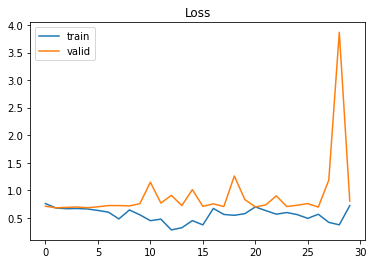

In [14]:
import matplotlib.pyplot as plt

epochs = np.arange(0,30)

plt.title('Loss') 
plt.plot(epochs, total_train_loss, label="train") 
plt.plot(epochs, total_valid_loss, label="valid") 
plt.legend()
plt.show()

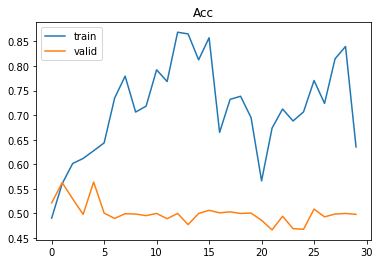

In [15]:
plt.title('Acc') 
plt.plot(epochs, total_train_acc, label="train") 
plt.plot(epochs, total_valid_acc, label="valid") 
plt.legend()
plt.show()